# Recommending Retail Items for Purchase  
In this notebook, I will be creating recommendations for items for purchase. An anonymous online retailer has provided a dataset of transactions on Kaggle, https://www.kaggle.com/datasets/satyajeetkumarraj/online-retail-dataset, which I'll be using. I'll use several collaborative filtering methods to generate recommendations and create an assessment mechanism to evaluate their performance. In the end, I'll recommend the use of one approach.

## Exploratory Data Analysis  
Before I build any models, I'll load, explore, and refine the data as necessary

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
purchases = pd.read_excel('./online_retail.xlsx')
purchases.info()
purchases.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
# Select and convert relevant columns
purchases = purchases.rename(columns={
    'Customer ID': 'customer',
    'StockCode': 'product',
    'InvoiceDate': 'timestamp'
})
purchases = purchases[['customer', 'product', 'timestamp']]

# Convert timestamp to epoch time for simple sorting
purchases['timestamp'] = pd.to_datetime(purchases['timestamp'])
purchases['timestamp'] = purchases['timestamp'].astype(int) // 10**9

In [5]:
# Count NAs
print(len(purchases))
purchases.isna().sum()
purchases = purchases.dropna()
print(len(purchases))

525461
417534


### About the Columns
This data has 8 columns:  
**Invoice** indicates which items were purchased together as part of the same transaction. It may be interesting to link products bought together in the same transaction, but I'm choosing to prioritise ites bought by the same customer and so will drop the column.  
**StockCode** is an id for each kind of product. This will be vital to my investigation.  
**Description** describes the product. This would be useful for any QA performed "by hand", looking at individual similarities or recommendations. Since I'm focusing on quantitative evaluation, this column is dropped.  
**Quantity** indicates how much of a single product is purchased at once. I choose to ignore this column on the theory that a single customer buying 100 of product A and 100 of product B does not mean they're 100 times more related than if they bought one of each.  
**Invoice Date** tells us down to the minute when a transaction is complete. This will be important for identifying the most recent purchase. I transform it to epoch time for easy sorting later.  
**Price** is how much the product costs. This is not important for this investigation and dropped.  
**Customer ID** is vital for linking together products and is saved.  
**Country** indicates the country of residence of the customer. I ignored this column, on the theory that customers from different countries don't behave that differently if they're visiting this same online store. I note that as a UK dataset, the UK is present in the preview.

So, I narrow my columns down to three: **Customer**, **Product**, and **Timestamp**. I do a quick check for null values of these core columns and remove any rows that have them missing. A substantial chunk of transactions are missing customer information.

### Purchase Trends

In [6]:
# Get time range in days
time_in_days = (purchases.timestamp.max() - purchases.timestamp.min()) / (60 * 60 * 24) # seconds to days
print(f'timerange in days {time_in_days}')

timerange in days 373.5111111111111


In [12]:
# Num customers, products, transactions
print(f'Unique customers: {len(purchases["customer"].unique())}')
print(f'Unique products: {len(purchases["product"].unique())}')
print(f'Number of purchases of products: {len(purchases)}')

Unique customers: 4383
Unique products: 4031
Number of purchases of products: 417534


Most purchases per visitor
       customer  purchase_count
1869   14911.0            5710
4058   17841.0            5114
1631   14606.0            3927
1291   14156.0            2710
254    12748.0            2665
4065   17850.0            2515
3081   16549.0            2274
2165   15311.0            2226
1570   14527.0            1826
1662   14646.0            1805
3249   16782.0            1703
511    13089.0            1581
1943   15005.0            1388
3709   17377.0            1377
503    13081.0            1369
1968   15039.0            1302
855    13564.0            1233
1401   14298.0            1228
2484   15768.0            1213
1689   14680.0            1138
3763   17448.0            1133
4114   17920.0            1110
3867   17589.0            1100
3807   17511.0            1058
957    13694.0             973


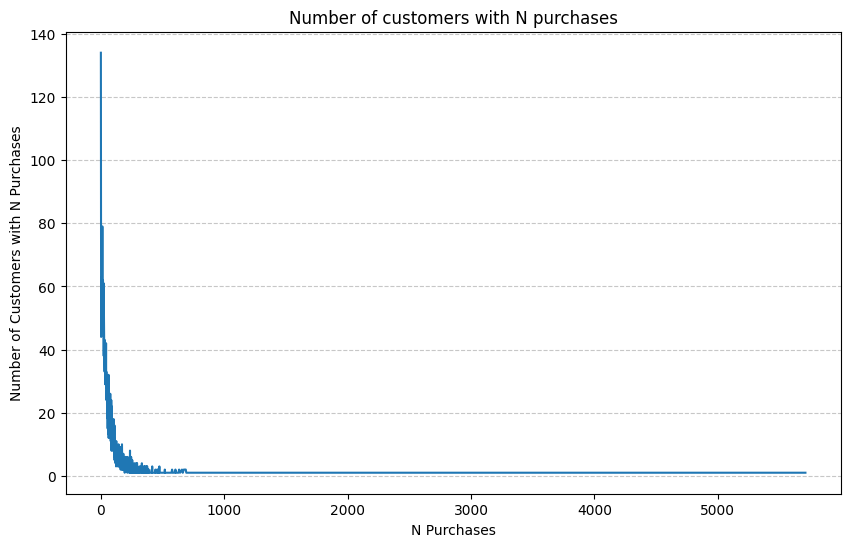

Mean purchase count per customer: 95.2621492128679
Median purchase count per customer: 44.0
Modal purchase count per customer: 0    1
Name: purchase_count, dtype: int64
Number of visitors with >1 purchase: 96.94273328770248
Number of visitors with >10 purchase: 85.37531371206936
Number of visitors with >100 purchase: 25.87268993839836


In [22]:
# Most purchases per user
purchases_per_customer = purchases.groupby('customer').size()
purchases_per_customer = purchases_per_customer.reset_index(name='purchase_count').sort_values(by='purchase_count', ascending=False)
print('Most purchases per visitor\n', purchases_per_customer.head(25))


customers_per_purchase_count = purchases_per_customer.groupby('purchase_count').size()
customers_per_purchase_count.reset_index(name='customers_per_purchase_count').sort_values(by='customers_per_purchase_count', ascending=False)
plt.figure(figsize=(10, 6))
visitors_per_purchase_count.plot(kind='line', title='Number of customers with N purchases')
plt.xlabel('N Purchases')
plt.ylabel('Number of Customers with N Purchases')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f'Mean purchase count per customer: {purchases_per_customer["purchase_count"].mean()}')
print(f'Median purchase count per customer: {purchases_per_customer["purchase_count"].median()}')
print(f'Modal purchase count per customer: {purchases_per_customer["purchase_count"].mode()}')

greater_one_purchase_customers = purchases_per_visitor[purchases_per_visitor['purchase_count'] > 1]
greater_one_purchase_customers_pct = len(greater_one_purchase_customers) / len(purchases_per_customer)
print(f'Number of visitors with >1 purchase: {100 * greater_one_purchase_customers_pct}')

greater_ten_purchases_customers = purchases_per_visitor[purchases_per_visitor['purchase_count'] > 10]
greater_ten_purchases_customers_pct = len(greater_ten_purchases_customers) / len(purchases_per_customer)
print(f'Number of visitors with >10 purchase: {100 * greater_ten_purchases_customers_pct}')

greater_hundred_purchases_customers = purchases_per_visitor[purchases_per_visitor['purchase_count'] > 100]
greater_hundred_purchases_customers_pct = len(greater_hundred_purchases_customers) / len(purchases_per_customer)
print(f'Number of visitors with >100 purchase: {100 * greater_hundred_purchases_customers_pct}')

### Comment on purchase trends
First, this data represents 417,534 purchases over 373.5 days. This data is sparse, since the mean purchase count is 95 products and the median purchase count is 44 products, but there are 4,000 products available. Customers typically interact with a small subset of products.  
The largest number of purchases for a single visitor is 5,710, which is pretty large, though we have to remember that these are purchases of individual products. That said, there is a dramatic power law in purchase number, with most visitors purchasing a very small amount, and very few visitors purchasing larger numbers of items over the sample period.  
Of course, only users with more than one purchase can possibly connect to products. Plausibly, customers with even more purchases will have a better signal to noise ratio. I created three datasets with customers having more than 1, more than 10, and more than 100 purchases. These represent 97%, 85%, and 26% of customers respectively. 

In [27]:
greater_one_purchase_set = greater_one_purchase_customers['customer'].tolist()
greater_one_purchases =  purchases[purchases['customer'].isin(greater_one_purchase_set)]
print('Greater Than One Purchase:')
print(f'Unique customers: {len(greater_one_purchases["customer"].unique())}')
print(f'Unique products: {len(greater_one_purchases["product"].unique())}')
print(f'Number of purchases of products: {len(greater_one_purchases)}\n')

print('Greater Than Ten Purchases:')
greater_ten_purchases_set = greater_ten_purchases_customers['customer'].tolist()
greater_ten_purchases =  purchases[purchases['customer'].isin(greater_ten_purchases_set)]
print(f'Unique customers: {len(greater_ten_purchases["customer"].unique())}')
print(f'Unique products: {len(greater_ten_purchases["product"].unique())}')
print(f'Number of purchases of products: {len(greater_ten_purchases)}\n')

print('Grearter Than One Hundred Purchases:')
greater_hundred_purchases_set = greater_hundred_purchases_customers['customer'].tolist()
greater_hundred_purchases =  purchases[purchases['customer'].isin(greater_hundred_purchases_set)]
print(f'Unique customers: {len(greater_hundred_purchases["customer"].unique())}')
print(f'Unique products: {len(greater_hundred_purchases["product"].unique())}')
print(f'Number of purchases of products: {len(greater_hundred_purchases)}')


# Redo the stats ?

Greater Than One Purchase:
Unique customers: 4249
Unique products: 4029
Number of purchases of products: 417400

Greater Than Ten Purchases:
Unique customers: 3742
Unique products: 4027
Number of purchases of products: 414331

Grearter Than One Hundred Purchases:
Unique customers: 1134
Unique products: 3972
Number of purchases of products: 304066


### Comment on purchase trends for multi-item purchasers
Limiting out data to customers with multiple purchases reduces the data size. There are 417,400 purchases of 4,029 products by 4,249 customers when thresholding by 1 purchase. There are 414,331 purchases of 4,027 products by 3,742 customers when thresholding by 10 purchases. And there are 304,066 purchases of 3,972 products by 1,134 customers when thresholding by 100 purchases.   
Based on these numbers, I expect the data to improve when increasing the threshold to 10, but I am not sure what will happen when threshholding by 100. 

### Time of Day Sanity Check
Now, I get a quick look at the time of day of these purchases, just to check that everything looks normal

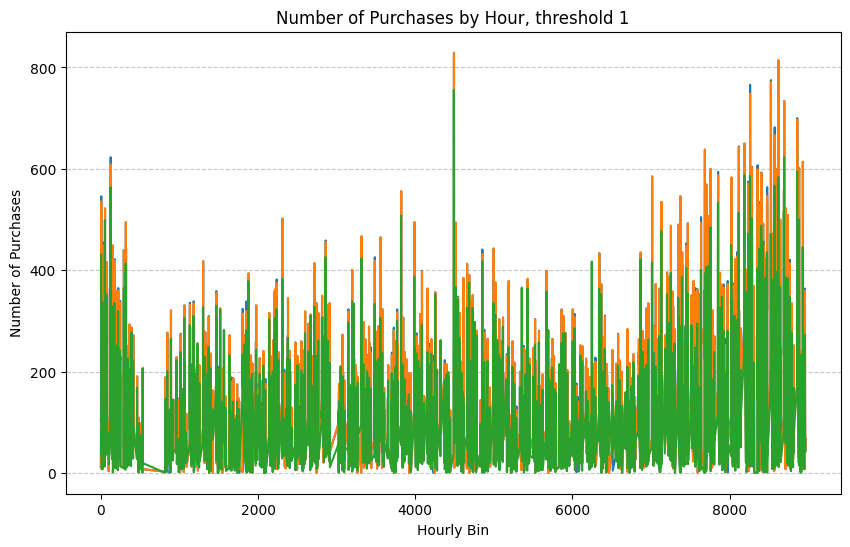

In [69]:
# Get an idea of purchase behavior over time. Graph num purchases binned by hour
min_hour = greater_one_purchases['timestamp'].min() // (60 * 60)
greater_one_purchases['hour'] = greater_one_purchases['timestamp'] // (60 * 60) - min_hour
greater_one_purchases_per_hour = greater_one_purchases.groupby('hour').size()

min_hour = greater_ten_purchases['timestamp'].min() // (60 * 60)
greater_ten_purchases['hour'] = greater_ten_purchases['timestamp'] // (60 * 60) - min_hour
greater_ten_purchases_per_hour = greater_ten_purchases.groupby('hour').size()


min_hour = greater_hundred_purchases['timestamp'].min() // (60 * 60)
greater_hundred_purchases['hour'] = greater_hundred_purchases['timestamp'] // (60 * 60) - min_hour
greater_hundred_purchases_per_hour = greater_hundred_purchases.groupby('hour').size()


plt.figure(figsize=(10, 6))
greater_one_purchases_per_hour.plot(kind='line', title='Number of Purchases by Hour, threshold 1')
greater_ten_purchases_per_hour.plot(kind='line', title='Number of Purchases by Hour, threshold 1')
greater_hundred_purchases_per_hour.plot(kind='line', title='Number of Purchases by Hour, threshold 1')
plt.xlabel('Hourly Bin')
plt.ylabel('Number of Purchases')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Final comment on trends
Third, the number of purchases per hour looks very smooth, with spikes as tall as ~800 and displaying normal time of day and day of year cycles. I note there is a time period of perhaps a few weeks where there are dramatically fewer purchases. I'm not sure why this is, perhaps the store stopped accepting orders at this time. I don't think it will ruin the analysis I'm going to do

With our dataset defined, let's start modeling
## Modeling
As stated, I'll be solving a recommendations problem. The recommendations will be products that are similar to products that a customer has purchased in the past. I'll explore several ways of creating item-item similarity matrices including Collaboartive Filtering with Cosine and Jaccard Similarity measures, as well as a Nonnegative Matrix Factorization that uses cosine similarity on the intermediate matrices. 


### Generating and evaluating recommendations
To find a given user's recommendations, I will take all of the products they've purchased and look up similar products in the provided similarities matrix. If a product is similar to multiple products in a user's purchase history, their score will be the sum of the similarity scores. Then, I rank the recommendations by score and take the top 50. Customers whose most recent purchase appear in their recommendations are considered a "success", and are otherwise considered a "fail" case. So, a recommender with an accuracy of 10% indicates that 10% of customers have their most recent purchase in their top 50 recommendations based on the past purchases.

A threshhold in recommendation amount is necessary so recommendations lists don't grow to cover a huge percentage of the available products. The threshold was kept fairly high (compared to the 5-10 generall shown on a website) in order to make obvious the difference between models. A small number of recommendations would result in uniformly low accuracy, making it harder to compare techniques. 

In [71]:
# Iterate over each user and their group of past purchases, pullin gout recommendations from the helper method above
def get_all_recommendations(past_purchases, sim_matrix, item_to_index, index_to_item):
    test_user_recommendations = {}
    for user, group in past_purchases.groupby('customer'):
        past_purchase_list = group['product'].tolist()
        test_user_recommendations[user] = get_recommendations_for_user(past_purchase_list, sim_matrix, item_to_index, index_to_item)
        
    return test_user_recommendations

def get_recommendations_for_user(past_purchase_list, sim_matrix, item_to_index, index_to_item):
    recommendation_scores = {}
    for item in past_purchase_list:
        if item in item_to_index:
            item_idx = item_to_index[item]
            # Get similarity scores directly from dense matrix
            similarity_scores = sim_matrix[item_idx]

            # Iterate through all items and accumulate scores. If the same item is similar to multiple past purchases, sum their scores
            for idx, score in enumerate(similarity_scores):
                if score == 0:
                    continue
                item = index_to_item[idx]
                #if score > 0 and index_to_item[idx] not in test_user_items:  # Skip items the user already interacted with
                recommendation_scores[item] = recommendation_scores.get(item, 0) + score
    
    # These scores are not very principled, limit to top ten by score, but don't return score info
    sorted_recommendations = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)
    top_recommendations = [item for item, _ in sorted_recommendations[:50]]

    return top_recommendations


# Finally, see if the next purchased item appears in the recommendations, recording successes and failures
def get_accuracy(recommendations, most_recent_purchases):
    successes = 0
    fails = 0
    for user, purchase in most_recent_purchases[['customer', 'product']].values:
        if purchase in recommendations[user]:
            successes = successes + 1
        else:
            fails = fails + 1
    return successes / (successes + fails)

#### Train and test dataset
I'll train purchase similarities on 80% of the customers with multiple purchases. Then, for the remaining 20% of customers, I'll separate their last purchase, which can be though of as a result label, from the rest of their past purchases. 

In [70]:
from sklearn.model_selection import train_test_split

# Do a split at the customer level 
greater_one_unique_customers = greater_one_purchases[['customer']].drop_duplicates()
greater_one_train_customers, greater_one_test_customers = train_test_split(greater_one_unique_customers, test_size=0.2, random_state=91)

# Use the customer level split to split the purchases data
greater_one_train = greater_one_purchases[greater_one_purchases['customer'].isin(greater_one_train_customers['customer'])]
greater_one_test = greater_one_purchases[greater_one_purchases['customer'].isin(greater_one_test_customers['customer'])]
print(f'Train and test sizes after splitting on customer: train: {len(greater_one_train)}, test: {len(greater_one_test)}')

# Now, separate out the most recent purchase from past purchases in the test dataset
test_greater_one_most_recent_purchase = greater_one_test.loc[greater_one_test.groupby('customer')['timestamp'].idxmax()]
test_greater_one_past_purchases = greater_one_test.drop(test_greater_one_most_recent_purchase.index)
print(f'Dataset sizes after splitting out most recent purchase: Most Recent: {len(test_greater_one_most_recent_purchase)}, Past: {len(test_greater_one_past_purchases)}')

# As a quick check, make sure they have the same number of customers
greater_one_most_recent_customers = test_greater_one_most_recent_purchase[['customer']].drop_duplicates()
greater_one_past_customer = test_greater_one_past_purchases[['customer']].drop_duplicates()
print(f'Latest and past purchase sizes after splitting out test customers: train: {len(greater_one_most_recent_customers)}, test: {len(greater_one_past_customer)}')


# Having verified this method, apply to other two dataset thresholds
greater_ten_unique_customers = greater_ten_purchases[['customer']].drop_duplicates()
greater_ten_train_customers, greater_ten_test_customers = train_test_split(greater_ten_unique_customers, test_size=0.2, random_state=91)
greater_ten_train = greater_ten_purchases[greater_ten_purchases['customer'].isin(greater_ten_train_customers['customer'])]
greater_ten_test = greater_ten_purchases[greater_ten_purchases['customer'].isin(greater_ten_test_customers['customer'])]
test_greater_ten_most_recent_purchase = greater_ten_test.loc[greater_ten_test.groupby('customer')['timestamp'].idxmax()]
test_greater_ten_past_purchases = greater_ten_test.drop(test_greater_ten_most_recent_purchase.index)

greater_hundred_unique_customers = greater_hundred_purchases[['customer']].drop_duplicates()
greater_hundred_train_customers, greater_hundred_test_customers = train_test_split(greater_hundred_unique_customers, test_size=0.2, random_state=91)
greater_hundred_train = greater_hundred_purchases[greater_hundred_purchases['customer'].isin(greater_hundred_train_customers['customer'])]
greater_hundred_test = greater_hundred_purchases[greater_hundred_purchases['customer'].isin(greater_hundred_test_customers['customer'])]
test_greater_hundred_most_recent_purchase = greater_hundred_test.loc[greater_hundred_test.groupby('customer')['timestamp'].idxmax()]
test_greater_hundred_past_purchases = greater_hundred_test.drop(test_greater_hundred_most_recent_purchase.index)


Train and test sizes after splitting on customer: train: 327400, test: 90000
Dataset sizes after splitting out most recent purchase: Most Recent: 850, Past: 89150
Latest and past purchase sizes after splitting out test customers: train: 850, test: 850


### Cosine Similarty

In [72]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

item_user_matrix_one = pd.crosstab(greater_one_train['product'], greater_one_train['customer'])
print(item_user_matrix_one.shape)

# Save the indices for later
item_to_index_one = {item: idx for idx, item in enumerate(item_user_matrix_one.index)}
index_to_item_one = {idx: item for item, idx in item_to_index_one.items()}

# This data is sparse, do sparse operations
sparse_item_user_matrix_one = csr_matrix(item_user_matrix_one)

# Now, create item similarity matrix
cosine_similarity_matrix_one = cosine_similarity(sparse_item_user_matrix_one, dense_output=True)
print(cosine_similarity_matrix_one.shape)

# Repeat for other thresholds
item_user_matrix_ten = pd.crosstab(greater_ten_train['product'], greater_ten_train['customer'])
item_to_index_ten = {item: idx for idx, item in enumerate(item_user_matrix_ten.index)}
index_to_item_ten = {idx: item for item, idx in item_to_index_ten.items()}
sparse_item_user_matrix_ten = csr_matrix(item_user_matrix_ten)
cosine_similarity_matrix_ten = cosine_similarity(sparse_item_user_matrix_ten, dense_output=True)

item_user_matrix_hundred = pd.crosstab(greater_hundred_train['product'], greater_hundred_train['customer'])
item_to_index_hundred = {item: idx for idx, item in enumerate(item_user_matrix_hundred.index)}
index_to_item_hundred = {idx: item for item, idx in item_to_index_hundred.items()}
sparse_item_user_matrix_hundred = csr_matrix(item_user_matrix_hundred)
cosine_similarity_matrix_hundred = cosine_similarity(sparse_item_user_matrix_hundred, dense_output=True)


(3981, 3399)
(3981, 3981)


In [73]:
cosine_recommendations_one = get_all_recommendations(test_greater_one_past_purchases, cosine_similarity_matrix_one, item_to_index_one, index_to_item_one)
cosine_accuracy_one = get_accuracy(cosine_recommendations_one, test_greater_one_most_recent_purchase)
print(f'Accuracy of cosine similarity based recommender, threshold at one: {cosine_accuracy}')

Accuracy of cosine similarity based recommender, threshold at one: 0.2564705882352941


In [74]:
cosine_recommendations_ten = get_all_recommendations(test_greater_ten_past_purchases, cosine_similarity_matrix_ten, item_to_index_ten, index_to_item_ten)
cosine_accuracy_ten = get_accuracy(cosine_recommendations_ten, test_greater_ten_most_recent_purchase)
print(f'Accuracy of cosine similarity based recommender, threshold at ten: {cosine_accuracy_ten}')

Accuracy of cosine similarity based recommender, threshold at ten: 0.2523364485981308


In [75]:
cosine_recommendations_hundred = get_all_recommendations(test_greater_hundred_past_purchases, cosine_similarity_matrix_hundred, item_to_index_hundred, index_to_item_hundred)
cosine_accuracy_hundred = get_accuracy(cosine_recommendations_hundred, test_greater_hundred_most_recent_purchase)
print(f'Accuracy of cosine similarity based recommender, threshold at one hundred: {cosine_accuracy_hundred}')

Accuracy of cosine similarity based recommender, threshold at one hundred: 0.17180616740088106


In [76]:
## Jaccard
from sklearn.metrics import pairwise_distances
jaccard_similarity_one = 1 - pairwise_distances(sparse_item_user_matrix_one.toarray(), metric="jaccard")
jaccard_recommendations_one = get_all_recommendations(test_greater_one_past_purchases, jaccard_similarity_one, item_to_index_one, index_to_item_one)
jaccard_accuracy_one = get_accuracy(jaccard_recommendations_one, test_greater_one_most_recent_purchase)
print(f'Accuracy of jaccard similarity based recommender, threshold at one: {jaccard_accuracy_one}')


Accuracy of jaccard similarity based recommender, threshold at one: 0.36470588235294116


In [77]:
jaccard_similarity_ten = 1 - pairwise_distances(sparse_item_user_matrix_ten.toarray(), metric="jaccard")
jaccard_recommendations_ten = get_all_recommendations(test_greater_ten_past_purchases, jaccard_similarity_ten, item_to_index_ten, index_to_item_ten)
jaccard_accuracy_ten = get_accuracy(jaccard_recommendations_ten, test_greater_ten_most_recent_purchase)
print(f'Accuracy of jaccard similarity based recommender, threshold at ten: {jaccard_accuracy_ten}')

Accuracy of jaccard similarity based recommender, threshold at ten: 0.3658210947930574


In [78]:
jaccard_similarity_hundred = 1 - pairwise_distances(sparse_item_user_matrix_hundred.toarray(), metric="jaccard")
jaccard_recommendations_hundred = get_all_recommendations(test_greater_hundred_past_purchases, jaccard_similarity_hundred, item_to_index_hundred, index_to_item_hundred)
jaccard_accuracy_hundred = get_accuracy(jaccard_recommendations_hundred, test_greater_hundred_most_recent_purchase)
print(f'Accuracy of jaccard similarity based recommender, threshold at one hundred: {jaccard_accuracy_hundred}')

Accuracy of jaccard similarity based recommender, threshold at one hundred: 0.20704845814977973


In [79]:
# NMF
from sklearn.decomposition import NMF
nmf_model = NMF(n_components=20, init='random', random_state=42)  # Tune n_components as needed
item_latent_features_one = nmf_model.fit_transform(sparse_item_user_matrix_one)  # Item latent features

# Step 2: Compute cosine similarity between items based on latent features
item_similarity_matrix_one = cosine_similarity(item_latent_features_one)
nmf_recommendations_one = get_all_recommendations(test_greater_one_past_purchases, item_similarity_matrix_one, item_to_index_one, index_to_item_one)
nmf_accuracy_one = get_accuracy(nmf_recommendations_one, test_greater_one_most_recent_purchase)
print(f'Accuracy of NMF-based recommender, threshold at one: {nmf_accuracy_one}')


Accuracy of NMF-based recommender, threshold at one: 0.13176470588235295


In [80]:
item_latent_features_ten = nmf_model.fit_transform(sparse_item_user_matrix_ten)  # Item latent features
item_similarity_matrix_ten = cosine_similarity(item_latent_features_ten)
nmf_recommendations_ten = get_all_recommendations(test_greater_ten_past_purchases, item_similarity_matrix_ten, item_to_index_ten, index_to_item_ten)
nmf_accuracy_ten = get_accuracy(nmf_recommendations_ten, test_greater_ten_most_recent_purchase)
print(f'Accuracy of NMF-based recommender, threshold at ten: {nmf_accuracy_ten}')

Accuracy of NMF-based recommender, threshold at ten: 0.09078771695594126


In [81]:
item_latent_features_hundred = nmf_model.fit_transform(sparse_item_user_matrix_hundred)
item_similarity_matrix_hundred = cosine_similarity(item_latent_features_hundred)
nmf_recommendations_hundred = get_all_recommendations(test_greater_hundred_past_purchases, item_similarity_matrix_hundred, item_to_index_hundred, index_to_item_hundred)
nmf_accuracy_hundred = get_accuracy(nmf_recommendations_hundred, test_greater_hundred_most_recent_purchase)
print(f'Accuracy of NMF-based recommender, threshold at one hundred: {nmf_accuracy_hundred}')

Accuracy of NMF-based recommender, threshold at one hundred: 0.030837004405286344


# Discussion
The following table shows the accuracies for each combination of purchase threshold and similarity measure
|       | > 1   | > 10   | > 100   |
|-------|------------|------------|------------|
| Cosine | 0.256   | 0.252   | 0.172  |
| Jaccard | 0.364   | 0.366   | 0.207  |
| NMF + Cosine | 0.132   | 0.091   | 0.031   |

Overall, these accuracy numbers are not high in an absolute sense. This makes a lot of sense to me, since we select only a max of 50 out of 4,000 products as recommendations, the base odds of the next purcase being in that list is not high. 

It seems that my attempt to improve recommendations with greater purchase thresholds mostly did not improve things. The accuracy for jaccard similarity at the 10 threshold is slightly greater than at the 1 threshold. Evidently, the signal thrown away from customers with fewer purchases outweighted any noise they brought in. The accuracies for the 10 threshold are close to the accuracies for the 1 threshold, which keep a similar amount of the raw data.

There also appears to be a clear ranking between recommendation algorithms: Jaccard first, Cosine second, NMF last.  
I expected NMF to be the worst performing. As a matrix decomposition algorithm, it doesn't handle sparsity that well. I also picked an arbitrary number of latent factors, 20, that seemed commensurate with broad product categories. Evidently though, what drives people to purchase specific _item_ is not well captures by this latent factor/category. Perhaps if I judged the _latent factor_ of the most recent purchase, I would have seen better results. While this might be useful for other kinds of website personalization, such as category sale targeting, it isn't suited to direct product recommendations.  
Cosine similarity is a marked improvement. This is likely due to its better behavior with sparse data. Only the products that are actually purchased factor into the similarities and reocmmendations, with missing interactions completely ignored.  
Jaccard similarity performs best of all. It notably improves when the threshold is increased. This distance measure might perform better than cosine because of the binary nature of purchase events. Whereas cosine similarity thinks the magnitudes matter, jaccard only looks for binary overlaps. Perhaps if I ran the analysis on purchase quantity, cosine similarity might have performed better than Jaccard.

# Conclusion

The goal of this project was to build a recommender for items to purchase based on past purchases to users of an unnamed UK online retailer. I created recommendations based on item-item similarities, generated three different ways: cosine similarity, jaccard similarity, and NMF with cosine similarity. I repeated this for three different purchase thresholds: 1, 10, and 100. In the end, I found that Jaccard consistently outperforms Cosine, which consistently outperforms NMF. The modest threshold of 10 purchases proved to be the highest accuracy.

There are many possible avenues for improvement here. One is to include the quantity purchased of ecah product. This data was available in the dataset, but was left out for simplicity. If quantity is important in drawing connections, cosine similarity might perform better. Another possible improvement is to use transactions to link together products instead of users. That would mean creating a transaction-product matrix instead of a user-product matrix. This seems more appropriate for a cart based recommender, but it's possible it would outperform in my test harness. Another improvement could be made by factoring in the time of purchase. Products that are purchased by the same customer are more likely to be similar if they're bought close together. This is sort of a generalization of the transaction level grouping I suggested earlier.  A final improvement might be to improve the way similarity scores are combined. This project focused on generating the similarity scores in different ways, but there are plenty of possible ways of combining scores that aren't just summing them at equal weights.

In the end, the results of this analysis suggest creating a recommender based on jaccard distances with a modest threshold of purchases.